# Analysis of Resource Ratios

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List
from fractions import Fraction

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
results_filename = "../data/resource_ratio/resource_ratio_paper_r_t40_s8_dt07-27_00-30-22.json"

with open(results_filename) as file:
    results_data = json.load(file)
    
print(f'Algorithms: {list(results_data[0]["ratio 0.1"].keys())}')

Algorithms: dict_keys(['Server Relaxed Flexible Optimal', 'Greedy Utility / Sqrt Sum, Sum, Percent Sum', 'Greedy Utility / Sqrt Sum, Sum, Pow percent sum', 'Greedy Utility / Sqrt Sum, Product, Percent Sum', 'Greedy Utility / Sqrt Sum, Product, Pow percent sum', 'Greedy Utility / Sqrt Sum, Random, Percent Sum', 'Greedy Utility / Sqrt Sum, Random, Pow percent sum', 'Greedy Utility * deadline / Sum, Sum, Percent Sum', 'Greedy Utility * deadline / Sum, Sum, Pow percent sum', 'Greedy Utility * deadline / Sum, Product, Percent Sum', 'Greedy Utility * deadline / Sum, Product, Pow percent sum', 'Greedy Utility * deadline / Sum, Random, Percent Sum', 'Greedy Utility * deadline / Sum, Random, Pow percent sum', 'Greedy Utility * deadline / Sqrt Sum, Sum, Percent Sum', 'Greedy Utility * deadline / Sqrt Sum, Sum, Pow percent sum', 'Greedy Utility * deadline / Sqrt Sum, Product, Percent Sum', 'Greedy Utility * deadline / Sqrt Sum, Product, Pow percent sum', 'Greedy Utility * deadline / Sqrt Sum, Ran

## Resource Ratio results

In [3]:
greedy_name = 'Greedy Utility / Sqrt Sum, Product, Pow percent sum'
fixed_greedy_name = 'Greedy Utility / Sqrt Sum, Product, Fixed Task Speeds'

algorithms = [('Greedy', greedy_name), ('Fixed Greedy', fixed_greedy_name)]
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_labels = ['1:9', '1:4', '3:7', '2:5', '1:1', '5:2', '7:3', '4:1', '9:1']

c:\users\markm\anaconda3\envs\flexible-cloud-resource\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


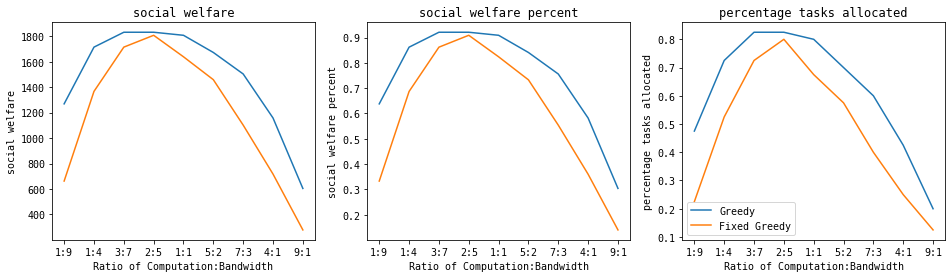

In [4]:
system_fig, (sw_ax, swp_ax, pta_ax) = plt.subplots(1, 3, figsize=(16, 4))
for ax, prop in [(sw_ax, 'social welfare'), (swp_ax, 'social welfare percent'), (pta_ax, 'percentage tasks allocated')]:
    for name, algo in algorithms:
        results = [results_data[0][f'ratio {ratio}'][algo][prop] for ratio in ratios]
        ax.plot(ratios, results, label=name)
    ax.set_title(prop)
    ax.set_xticklabels(ratio_labels)
    ax.set_xlabel('Ratio of Computation:Bandwidth')
    ax.set_ylabel(prop)
    ax.set_xticks(ratios)
    
# plt.legend(bbox_to_anchor=(0, -0.1))
plt.legend()

c:\users\markm\anaconda3\envs\flexible-cloud-resource\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Save file location: figs/resource_ratio/eps/server_resource_usage.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/resource_ratio/png/server_resource_usage.png
Save file location: figs/resource_ratio/pdf/server_resource_usage.pdf


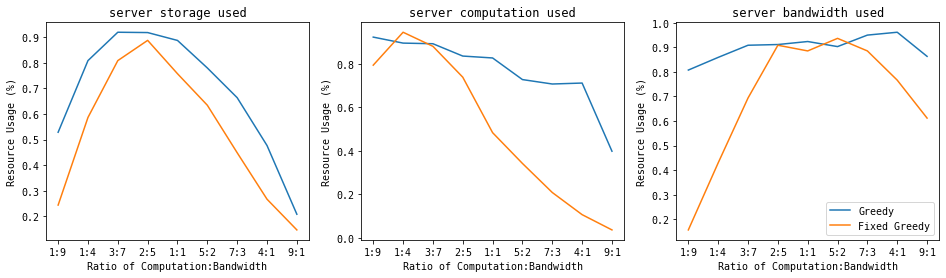

In [5]:
server_fig, (ax_storage_used, ax_computation_used, ax_bandwidth_used) = plt.subplots(1, 3, figsize=(16, 4))
for ax, prop in [(ax_storage_used, 'server storage used'), (ax_computation_used, 'server computation used'), 
                 (ax_bandwidth_used, 'server bandwidth used')]:
    for name, algo in algorithms:
        results = [np.mean(list(results_data[0][f'ratio {ratio}'][algo][prop].values())) for ratio in ratios]
        ax.plot(ratios, results, label=name)
    ax.set_xticklabels(ratio_labels)
    ax.set_xticks(ratios)
    ax.set_ylabel('Resource Usage (%)')
    ax.set_xlabel('Ratio of Computation:Bandwidth')
    ax.set_title(prop)

# plt.legend(bbox_to_anchor=(0, -0.1))
plt.legend()
save_plot('server_resource_usage', 'resource_ratio')

## Resource ratio social welfare percentage average

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/resource_ratio/eps/social_welfare.eps
Save file location: figs/resource_ratio/png/social_welfare.png
Save file location: figs/resource_ratio/pdf/social_welfare.pdf


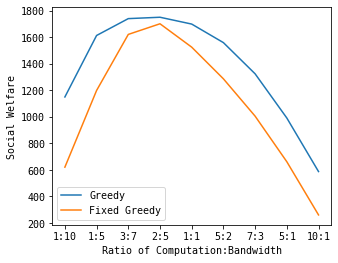

In [10]:
avg_fig, swp_avg_ax = plt.subplots(figsize=(5, 4))
for name, algo in algorithms:
    swp_avg_ax.plot(ratios, [np.mean([result[f'ratio {ratio}'][algo]['social welfare'] 
                                      for result in results_data]) for ratio in ratios], label=name)

swp_avg_ax.set_ylabel('Social Welfare', fontsize=10)
swp_avg_ax.set_xlabel('Ratio of Computation:Bandwidth', fontsize=10)
plt.xticks(ticks=ratios, labels=['1:10', '1:5', '3:7', '2:5', '1:1', '5:2', '7:3', '5:1', '10:1'])

plt.legend()
save_plot('social_welfare', 'resource_ratio')

In [7]:
for ratio in ratios:
    difference = round(np.mean([r[f'ratio {ratio}'][greedy_name]['social welfare percent'] - 
                                r[f'ratio {ratio}'][fixed_greedy_name]['social welfare percent']
                                for r in results_data]), 3)
    print(f'Ratio: {ratio}, difference: {difference}')

Ratio: 0.1, difference: 0.268
Ratio: 0.2, difference: 0.21
Ratio: 0.3, difference: 0.06
Ratio: 0.4, difference: 0.025
Ratio: 0.5, difference: 0.089
Ratio: 0.6, difference: 0.138
Ratio: 0.7, difference: 0.162
Ratio: 0.8, difference: 0.167
Ratio: 0.9, difference: 0.166


## Resource ratio social welfare difference

Save file location: figs/resource_ratio/eps/social_welfare_difference.eps
Save file location: figs/resource_ratio/png/social_welfare_difference.png
Save file location: figs/resource_ratio/pdf/social_welfare_difference.pdf


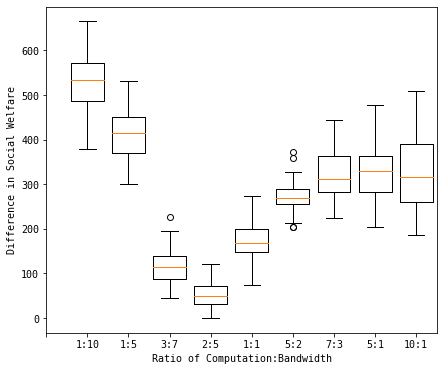

In [8]:
diff_fig, diff_ax = plt.subplots(figsize=(7, 6))

differences = [
    [result[f'ratio {ratio}'][greedy_name]['social welfare'] - 
     result[f'ratio {ratio}'][fixed_greedy_name]['social welfare']
     for result in results_data]
    for ratio in ratios
]

diff_ax.boxplot(differences, widths=0.8)
diff_ax.set_ylabel('Difference in Social Welfare')
plt.xticks(ticks=np.arange(len(ratios)+1), labels=['', '1:10', '1:5', '3:7', '2:5', '1:1', '5:2', '7:3', '5:1', '10:1'])
diff_ax.set_xlabel('Ratio of Computation:Bandwidth')
save_plot('social_welfare_difference', 'resource_ratio')